In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import welch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [17]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


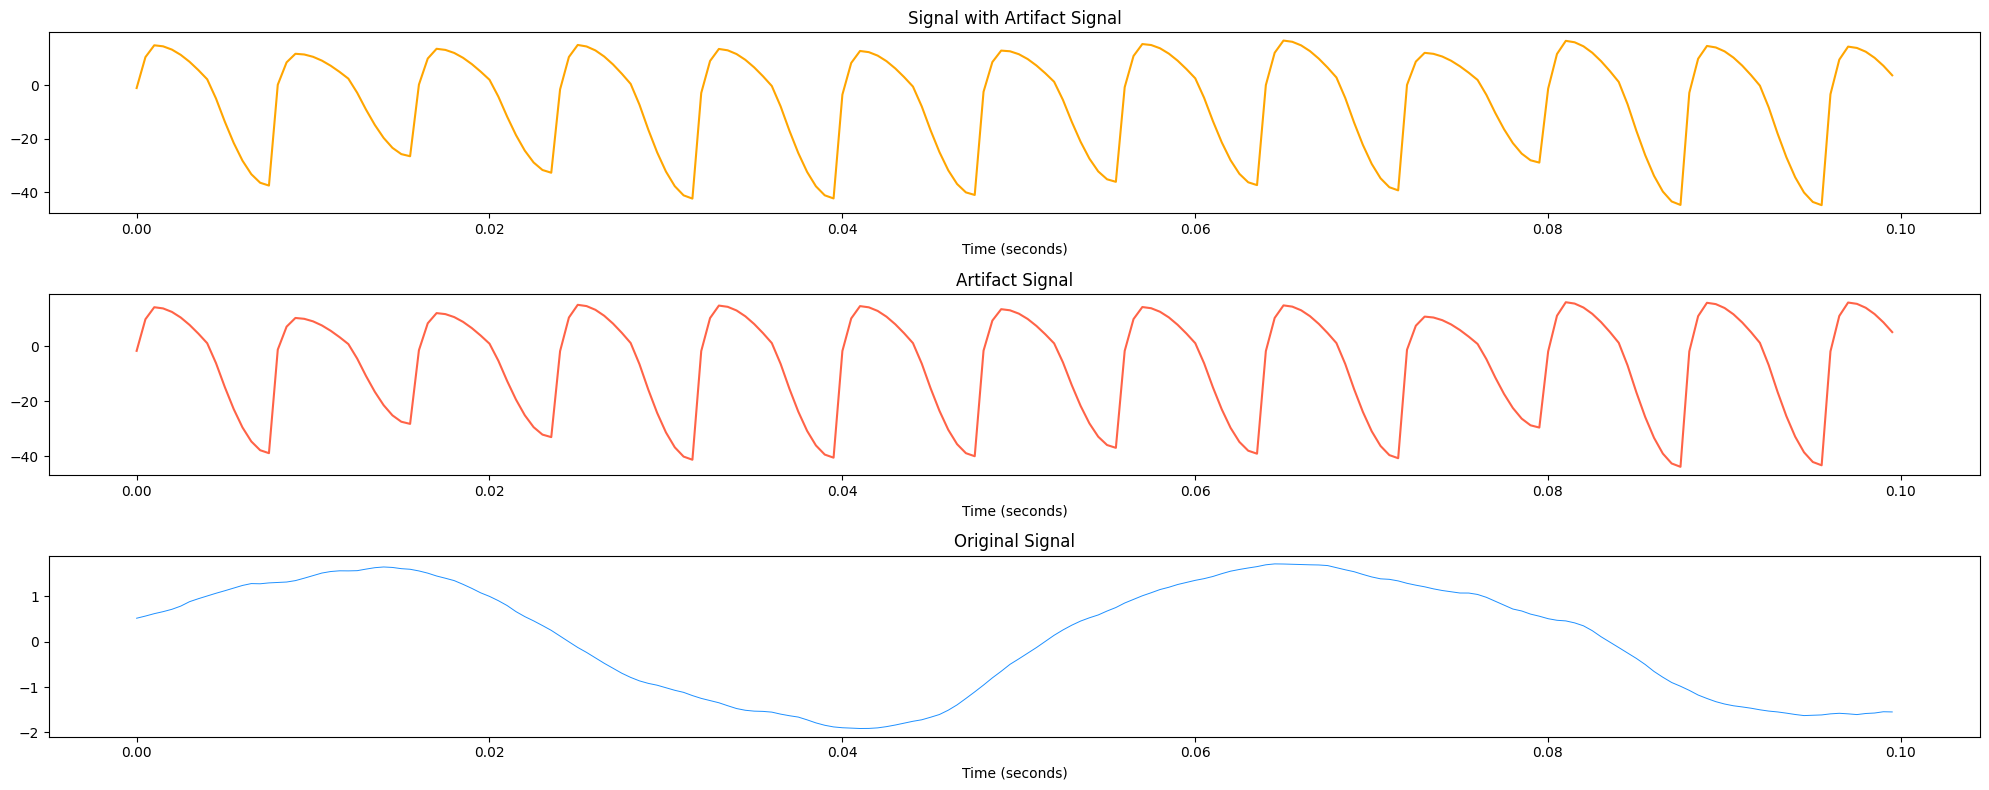

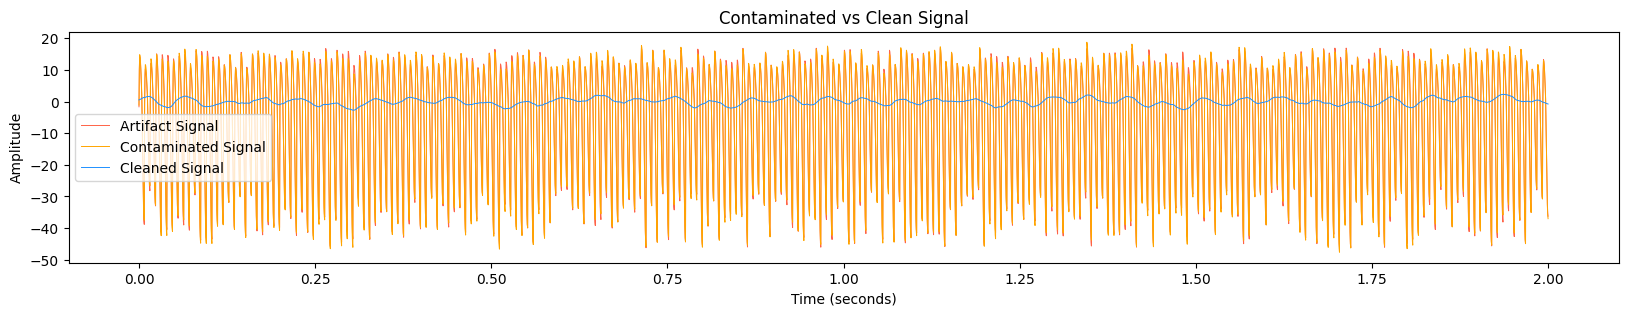

In [18]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange');plt.xlabel("Time (seconds)");plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato');plt.xlabel("Time (seconds)");plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue', linewidth = 0.7);plt.xlabel("Time (seconds)");plt.title('Original Signal')
# plt.xlim(0.0270, 0.0280)
# plt.ylim(-0.75, -0.65)

plt.tight_layout()

plt.figure(figsize=(20, 3))
plt.plot(t, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, sig_with_artifact[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, sig[0], label='Cleaned Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal');plt.legend();plt.show()

In [19]:
# z-score normalization
scaler = StandardScaler()

sig_with_artifact = scaler.fit_transform(sig_with_artifact.T)
sig = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

sig_with_artifact = sig_with_artifact.T; sig = sig.T

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


(1000, 2001)
(1000, 2001)
(2001,)


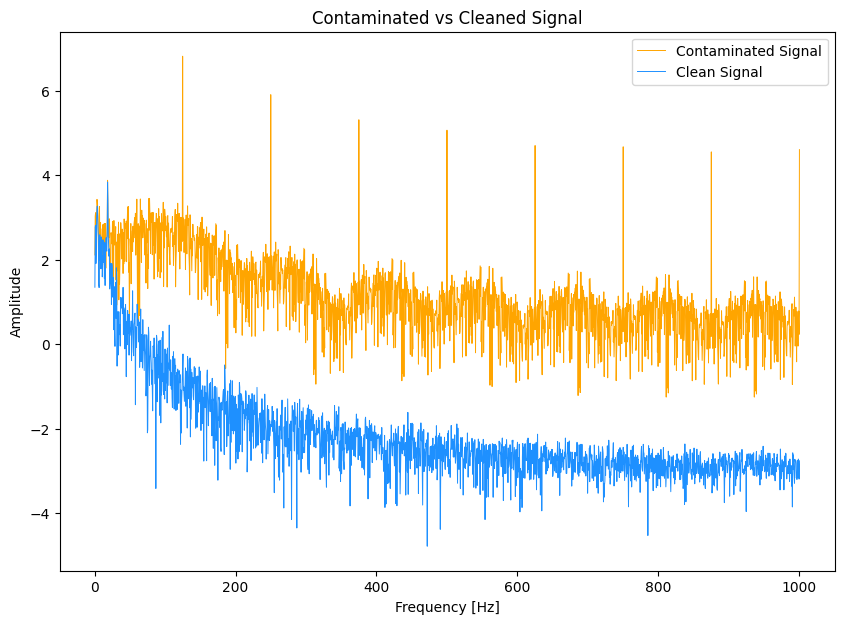

(1000, 2001)
(1000, 2001)
(2001,)


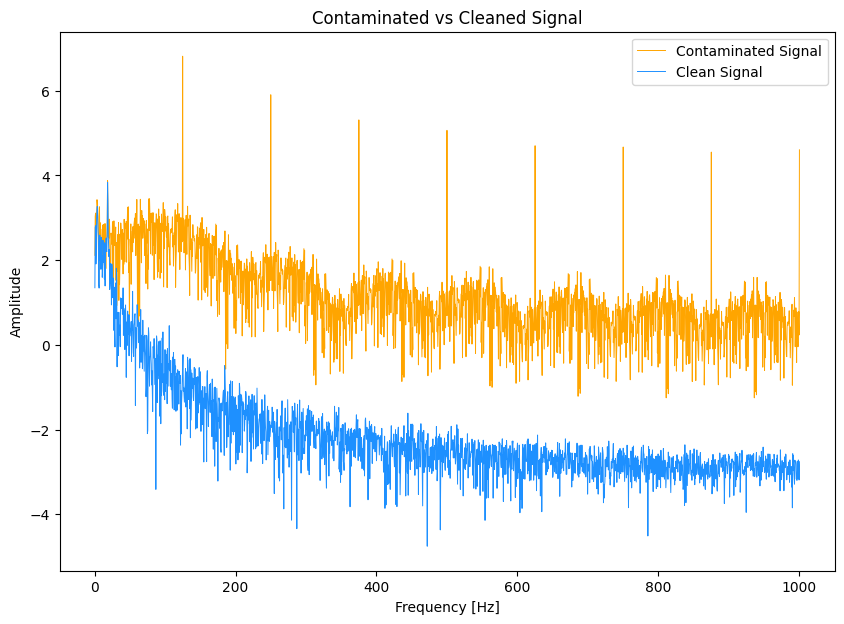

In [20]:
# power spectrum으로 변환
n = len(sig_with_artifact[0])

fs = 2000
freqs = np.fft.rfftfreq(n, d=1/fs)

fft_contaminated = np.fft.rfft(sig_with_artifact, axis=1)
power_contaminated = np.abs(fft_contaminated)**2

fft_clean = np.fft.rfft(sig, axis=1)
power_clean = np.abs(fft_clean)**2

print(power_contaminated.shape)
print(power_clean.shape)
print(freqs.shape)

plt.figure(figsize=(10, 7))
plt.plot(freqs[1:], np.log10(power_contaminated[0][1:]), label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(freqs[1:], np.log10(power_clean[0][1:]), label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude');plt.title('Contaminated vs Cleaned Signal');plt.legend();plt.show()

# Data preprocessing
X = np.log10(power_contaminated + 1e-6)
y = np.log10(power_clean + 1e-6)

print(X.shape)
print(y.shape)
print(freqs.shape)

plt.figure(figsize=(10, 7))
plt.plot(freqs[1:], X[0][1:], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(freqs[1:], y[0][1:], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude');plt.title('Contaminated vs Cleaned Signal');plt.legend();plt.show()

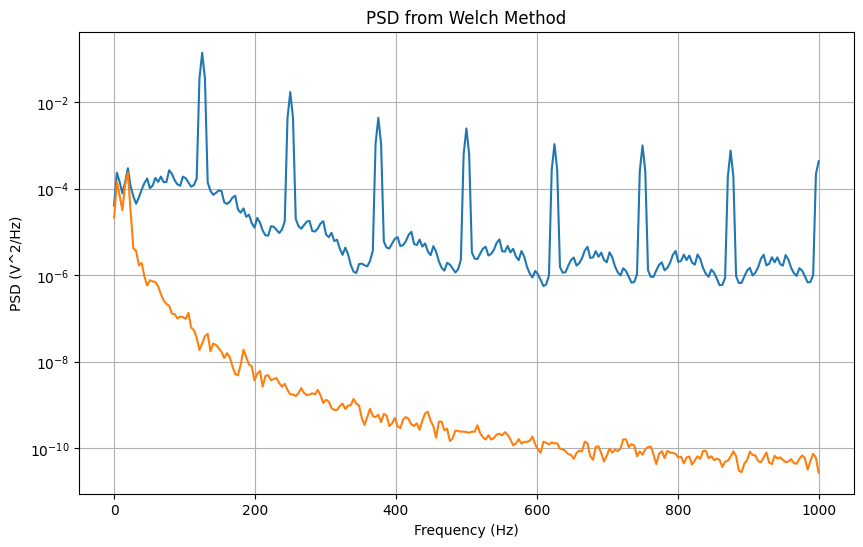

Contaminated frequency.shape: (1000, 257)
Contaminated PSD.shape: (1000, 257)
frequency.shape: (1000, 257)
PSD.shape: (1000, 257)


In [33]:
# Welch's method 매개변수
nperseg = 512  # 각 세그먼트의 길이

# 각 시계열 데이터에 대해 Welch's method 적용하여 주파수 및 PSD 계산
Contaminated_results = [welch(sig_with_artifact[i], fs, nperseg=nperseg) for i in range(len(sig_with_artifact))]
Clean_results = [welch(sig[i], fs, nperseg=nperseg) for i in range(len(sig))]

# 결과를 주파수와 PSD 리스트로 분리
Contaminated_frequencies_list, Contaminated_psd_list = zip(*Contaminated_results)
Clean_frequencies_list, Clean_psd_list = zip(*Clean_results)

# 첫 번째 시계열 데이터의 PSD 결과를 플로팅
plt.figure(figsize=(10, 6))
plt.semilogy(Contaminated_frequencies_list[0], Contaminated_psd_list[0])
plt.semilogy(Clean_frequencies_list[0], Clean_psd_list[0])
plt.title('PSD from Welch Method')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid()
plt.show()

# 주파수와 PSD 결과를 배열로 변환
Contaminated_frequencies_array = np.array(Contaminated_frequencies_list)
Contaminated_psd_array = np.array(Contaminated_psd_list)
Clean_frequencies_array = np.array(Clean_frequencies_list)
Clean_psd_array = np.array(Clean_psd_list)

print(f"Contaminated frequency.shape: {Contaminated_frequencies_array.shape}")
print(f"Contaminated PSD.shape: {Contaminated_psd_array.shape}")
print(f"frequency.shape: {Clean_frequencies_array.shape}")
print(f"PSD.shape: {Clean_psd_array.shape}")

# X = np.log10(Contaminated_psd_array)
# y = np.log10(Clean_psd_array)
X = Contaminated_psd_array
y = Clean_psd_array

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x F, y : B x F
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("unsqueezed X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x F, y : B x F
print("unsqueezed X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 257)
y_train shape: (800, 257)
X_test shape: (200, 257)
y_test shape: (200, 257)
unsqueezed X_train shape: (800, 257, 1)
y_train shape: (800, 257)
unsqueezed X_test shape: (200, 257, 1)
y_test shape: (200, 257)


In [23]:
class LSTM_Block(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Block, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)

        self.gelu = nn.GELU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        out = self.gelu(output)

        return out
    
class simpleLSTM1d(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        self.inputlayer = LSTM_Block(input_size, hidden_size, 1)

        self.net = nn.Sequential(*[ LSTM_Block(hidden_size, hidden_size, 1) for i in range(num_layers)])
        
        self.outputlayer = LSTM_Block(hidden_size, output_size, 1)

    def forward(self, x): # B x T x 1
        x = self.gelu(self.dropout(self.inputlayer(x))) # x: B x T x 128
        x = self.net(x) # x: B x T x 128
        x = self.outputlayer(x).squeeze(-1) # x: B x T x 1 -> B x T
        x = self.gelu(x)

        return x

In [24]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 32  # 임의의 hidden layer 크기
output_size = 1  # 출력 크기
num_layers = 2  # 임의의 LSTM layer 개수

model = simpleLSTM1d(input_size, hidden_size, output_size, num_layers).to(device)
print(model)

# 손실 함수와 옵티마이저 정의
lr = 1e-3
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10)

simpleLSTM1d(
  (dropout): Dropout(p=0.2, inplace=False)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
  (inputlayer): LSTM_Block(
    (lstm): LSTM(1, 32, batch_first=True)
    (gelu): GELU(approximate='none')
  )
  (net): Sequential(
    (0): LSTM_Block(
      (lstm): LSTM(32, 32, batch_first=True)
      (gelu): GELU(approximate='none')
    )
    (1): LSTM_Block(
      (lstm): LSTM(32, 32, batch_first=True)
      (gelu): GELU(approximate='none')
    )
  )
  (outputlayer): LSTM_Block(
    (lstm): LSTM(32, 1, batch_first=True)
    (gelu): GELU(approximate='none')
  )
)


In [25]:
# 모델 훈련
num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    
    scheduler.step()

Epoch 5/200, Loss: 7.434127837768756e-06
Epoch 10/200, Loss: 7.060271400405327e-06
Epoch 15/200, Loss: 5.528844667423982e-06
Epoch 20/200, Loss: 5.112312464916613e-06
Epoch 25/200, Loss: 3.574647053028457e-06
Epoch 30/200, Loss: 3.197813839506125e-06
Epoch 35/200, Loss: 2.2927285954210674e-06
Epoch 40/200, Loss: 2.127465450030286e-06
Epoch 45/200, Loss: 1.6192736893572146e-06
Epoch 50/200, Loss: 1.4986735550337471e-06
Epoch 55/200, Loss: 1.1296407365080086e-06
Epoch 60/200, Loss: 1.0432194130771677e-06
Epoch 65/200, Loss: 7.726358717263793e-07
Epoch 70/200, Loss: 7.098573178154766e-07
Epoch 75/200, Loss: 5.260566808829026e-07
Epoch 80/200, Loss: 4.873183456766128e-07
Epoch 85/200, Loss: 3.730281150637893e-07
Epoch 90/200, Loss: 3.4792284964169085e-07
Epoch 95/200, Loss: 2.730706398779148e-07
Epoch 100/200, Loss: 2.561069152307027e-07
Epoch 105/200, Loss: 2.0195653860355378e-07
Epoch 110/200, Loss: 1.9011429230886279e-07
Epoch 115/200, Loss: 1.504167528310063e-07
Epoch 120/200, Loss: 1.

In [26]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x F x 1
        y = batch[1] # y : B x F
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x F

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')     

Validation Loss: 1.2211707201004174e-08


(1000, 257)
torch.Size([257])


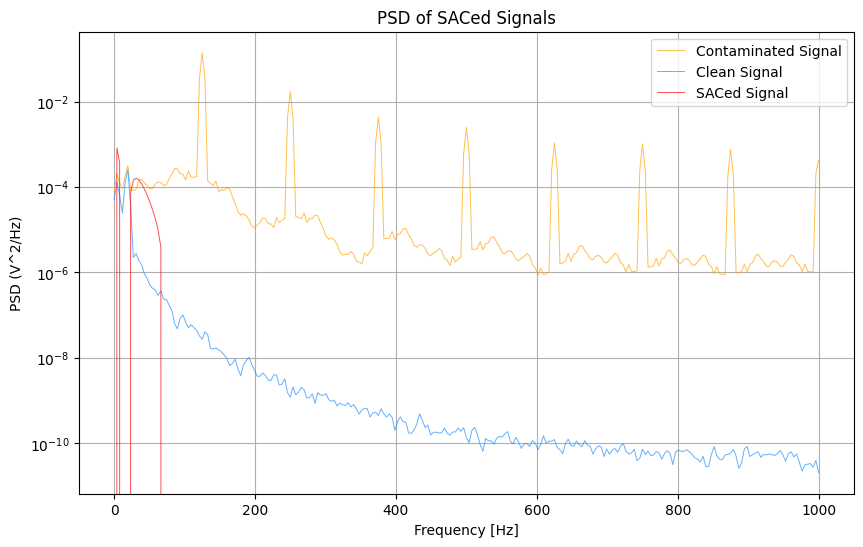

Mean Absolute Error: 2.3796015739208087e-05
Mean Squared Error: 1.2338475130491133e-08


In [31]:
Contaminated_signal = Contaminated[0]
Clean_signal = Clean[0]
SACed_signal = SACed[0]

# frequency domain plotting

print(Contaminated_frequencies_array.shape)
print(SACed_signal.shape)

plt.figure(figsize=(10, 6))
plt.semilogy(Contaminated_frequencies_array[1], Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.semilogy(Contaminated_frequencies_array[1], Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.semilogy(Contaminated_frequencies_array[1], SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('PSD of SACed Signals')
plt.xlabel('Frequency [Hz]');plt.ylabel('PSD (V^2/Hz)');plt.legend();plt.grid(True);plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(SACed_signal, Clean_signal)}")
print(f"Mean Squared Error: {mean_squared_error(SACed_signal, Clean_signal)}")

(2001,)
torch.Size([257])


ValueError: x and y must have same first dimension, but have shapes (2001,) and (257,)

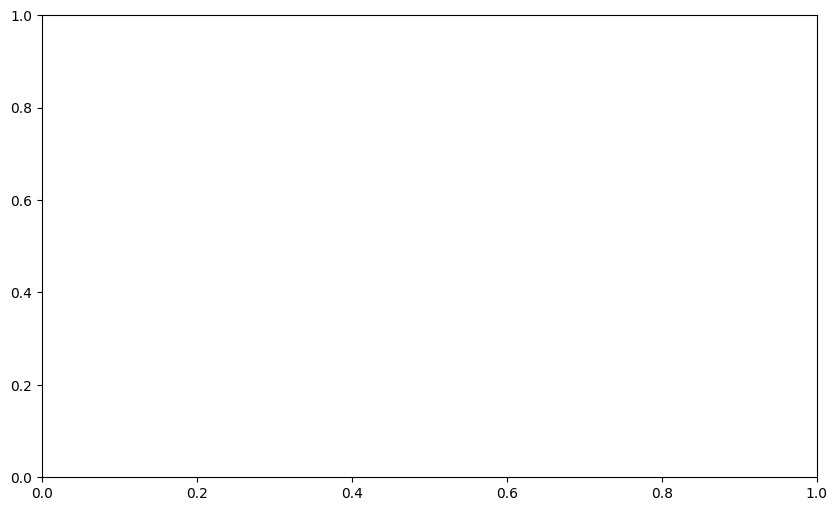

In [27]:
Contaminated_signal = Contaminated[0]
Clean_signal = Clean[0]
SACed_signal = SACed[0]

# frequency domain plotting

print(freqs.shape)
print(SACed_signal.shape)

plt.figure(figsize=(10, 6))
plt.plot(freqs, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of SACed Signals')
plt.xlabel('Frequency [Hz]');plt.ylabel('Power');plt.legend();plt.grid(True);plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(SACed_signal, Clean_signal)}")
print(f"Mean Squared Error: {mean_squared_error(SACed_signal, Clean_signal)}")

ValueError: x and y must have same first dimension, but have shapes (4000,) and (2001,)

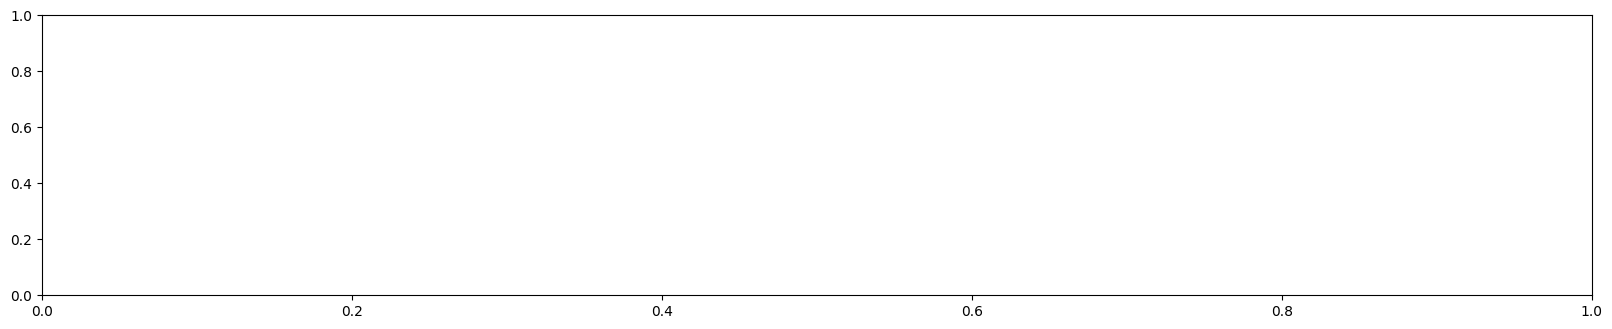

In [ ]:
# inverse fourier transform

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('LSTM result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")